In [1]:
from select_top_counts import select_top_counts

selected = select_top_counts()

In [2]:
top = set(selected
    .sort_values('count', ascending=False)
    .iloc[: 150000, :]
    .lower_title.values.tolist()
)

del(selected)

In [3]:
import json

ids = []
with open('data/cleaned.jsonl', 'r') as file:
    for line in file:
        j = json.loads(line)
        if j['lower_title'] not in top:
            continue
        del(j['clean_text'])
        ids.append(j)

In [4]:
top_ids = set([x['id'] for x in ids])
del(ids)

In [5]:
from sklearn.cluster import KMeans
import numpy as np
import json
import base64
import pandas as pd

X = []
with open('data/embeddings.jsonl', 'r') as file:
    for line in file:
        j = json.loads(line)
        if j['id'] not in top_ids:
            continue
        if j['embedding'] is None:
            continue
        j['embedding'] = np.frombuffer(base64.b64decode(j['embedding']))
        X.append(j)
X = pd.DataFrame(X)

In [6]:
X = np.array([x for x in X.embedding.to_numpy()])

# Select N

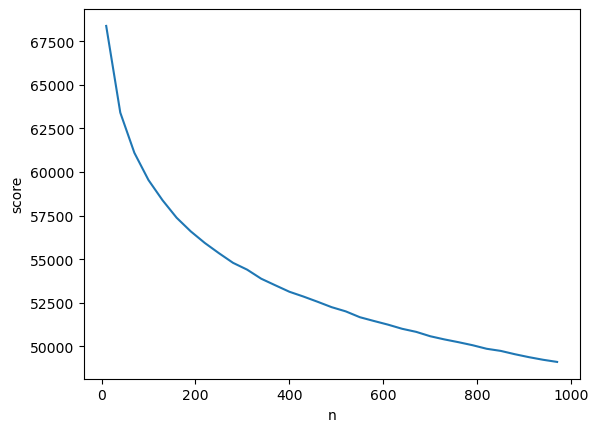

In [7]:
# import seaborn as sns

# data = []
# for n in range(10, 1000, 30):
#     km = KMeans(n).fit(X)
#     data.append({'n': n, 'score': km.inertia_})

# sns.lineplot(data=pd.DataFrame(data), x='n', y='score')

# Make clusters

In [8]:
N = 200

km = KMeans(N).fit(X)

In [13]:
km.cluster_centers_.sort(axis=0)

In [16]:
import sqlite3
from numpy.linalg import norm

try:
    conn = sqlite3.Connection('data/data.db')
    cur = conn.cursor()

    QUERY = "select id, vector from embeddings"
    cur.execute(QUERY)

    data = []
    i = 0
    while True:
        i += 1
        if i % 10000 == 0:
            print(i)
        row = cur.fetchone()
        if not row:
            break

        id, vector = row
        guess = np.frombuffer(vector)

        clusters = km.cluster_centers_
        distances = []

        try:
            for center in clusters:
                distances.append(norm(guess - center))
            assigment = np.argmin(distances) + 1
            data.append({'id': id, 'cluster': int(assigment)})
        except Exception as e:
            print(e)

    print(len(data))
    
except Exception as e:
    print(e)
finally:
    conn.close()



10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
operands could not be broadcast together with shapes (0,) (1536,) 
operands could not be broadcast together with shapes (0,) (1536,) 
operands could not be broadcast together with shapes (0,) (1536,) 
operands could not be broadcast together with shapes (0,) (1536,) 
operands could not be broadcast together with shapes (0,) (1536,) 
operands could not be broadcast together with shapes (0,) (1536,) 
operands could not be broadcast together with shapes (0,) (1536,) 
operands could not be broadcast together with shapes (0,) (1536,) 
operands could not be broadcast together with shapes (0,) (1536,) 
operands could not be broadcast together with shapes (0,) (1536,) 
operands could not be broadcast together with shapes (0,) (1536,) 
operands could not be broadcast together with shapes (0,) (1536,) 
operands could not be broadcast together with shapes (0,) (1536,) 
operands could not be broadcast together with s

In [17]:
with open('data/clusters.jsonl', 'a', encoding='utf-8') as file:
    for row in data:
        file.write(json.dumps(row) + '\n')